In [ ]:
# @title Monta il drive su colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Setup Librerie
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# @title Creo un dataframe contenenete le info sulle query/annotations

# Carica i JSON
train = json.load(open('/content/drive/MyDrive/backup_colab/content/ego4d_data/v1/annotations/nlq_train.json'))
val   = json.load(open('/content/drive/MyDrive/backup_colab/content/ego4d_data/v1/annotations/nlq_val.json'))
test  = json.load(open('/content/drive/MyDrive/backup_colab/content/ego4d_data/v1/annotations/nlq_test_unannotated.json'))
ego4d = json.load(open('/content/drive/MyDrive/backup_colab/content/ego4d_data/ego4d.json'))

# Funzione di estrazione delle informazioni relative alle queries
def extract_queries(data, include_windows=True):
    rows = []
    for v in data['videos']:
        # Leggo split direttamente dal JSON
        split = v.get('split')
        vid   = v['video_uid']
        for clip in v['clips']:
            for ann in clip.get('annotations', []):
                for q in ann.get('language_queries', []):
                    row = {
                        'split':     split,       # ← split preso dal JSON
                        'video_uid': vid,
                        'template':  q.get('template')
                    }
                    # Aggiungo window_length solo per train/val, perché nel test
                    # non ci sono tempi in language_queries
                    if include_windows and 'clip_start_sec' in q:
                        row['window_length'] = (
                            q['clip_end_sec'] - q['clip_start_sec']
                        )
                    rows.append(row)
    return pd.DataFrame(rows)

# Creo un unico DataFrame con tutte le query
df_all = pd.concat([
    extract_queries(train, include_windows=True),
    extract_queries(val,   include_windows=True),
    extract_queries(test,  include_windows=False)
], ignore_index=True)

# Ora df_all ha queste colonne:
#   - split:       'train', 'val' o 'test' (prelevato dal JSON)
#   - video_uid:   id del video
#   - template:    il template della query (o None se mancante)
#   - window_length: (solo per train/val) durata finestra di risposta in secondi

print(df_all.head())
print(df_all.split.value_counts())


   split                             video_uid  \
0  train  d250521e-5197-44aa-8baa-2f42b24444d2   
1  train  d250521e-5197-44aa-8baa-2f42b24444d2   
2  train  d250521e-5197-44aa-8baa-2f42b24444d2   
3  train  d250521e-5197-44aa-8baa-2f42b24444d2   
4  train  d250521e-5197-44aa-8baa-2f42b24444d2   

                                            template  window_length  
0         Objects: How many X’s? (quantity question)       43.66570  
1                           Objects: What X did I Y?        4.45100  
2     Objects: In what location did I see object X ?        9.50145  
3                      Objects: What did I put in X?        3.99232  
4  Objects: Where is object X before / after even...        1.35800  
split
train    11296
test      4005
val       3875
Name: count, dtype: int64


In [ ]:
# @title NLQ dataset statistics across the train/val/test splits

# 1) Durata in ore per split
# clip['clip_end_sec'] - clip['clip_start_sec'] ti dà la durata in secondi di quel
# frammento di video che è stato “tagliato” per l’annotazione.
# Iterando su tutti i clip di tutti i video in uno split e sommando queste durate,
# ottieni i secondi totali di video effettivamente utilizzati.

video_hours = {}
for split, data in [('train', train), ('val', val), ('test', test)]:
    total_sec = 0  # accumulatore di secondi per questo split
    for v in data['videos']:               # itero su ogni video nel JSON dello split
        for clip in v['clips']:            # itero su ogni clip di quel video
            # calcolo la durata del singolo clip
            total_sec += clip['clip_end_sec'] - clip['clip_start_sec']
    # converto i secondi totali in ore e li salvo per questo split
    video_hours[split] = total_sec / 3600

# 2) Clip count per split: conto quanti segmenti (clip) ci sono in totale in ciascuno split

# Per ciascun split itera su tutti i video (train['videos'], ecc.)
# e conteggia quanti elementi ci sono in v['clips'], sommando poi tutti questi conteggi.

clip_counts = {
  'train': sum(len(v['clips']) for v in train['videos']),  # per ogni video in train, aggiungo il numero di clip
  'val':   sum(len(v['clips']) for v in val['videos']),    # idem per validation
  'test':  sum(len(v['clips']) for v in test['videos'])    # idem per test
}

# 3) Query count per split: conto quante righe (query) ci sono in df_all per ciascun split
query_counts = {
  'train': len(df_all[df_all.split == 'train']),  # numero di query etichettate "train"
  'val':   len(df_all[df_all.split == 'val']),    # numero di query etichettate "val"
  'test':  len(df_all[df_all.split == 'test'])    # numero di query etichettate "test"
}

# 4) Creo il DataFrame finale con le tre statistiche per split
df_stats = pd.DataFrame([
    ('train', video_hours['train'], clip_counts['train'], query_counts['train']),
    ('val',   video_hours['val'],   clip_counts['val'],   query_counts['val']),
    ('test',  video_hours['test'],  clip_counts['test'],  query_counts['test']),
], columns=['split','video_hours','clips','queries']).set_index('split')

# 5) Visualizzo la tabella trasposta per comodità (split diventano colonne)
print(df_stats.transpose())


split               train         val         test
video_hours    136.881625    45.45996    45.669009
clips          998.000000   328.00000   333.000000
queries      11296.000000  3875.00000  4005.000000


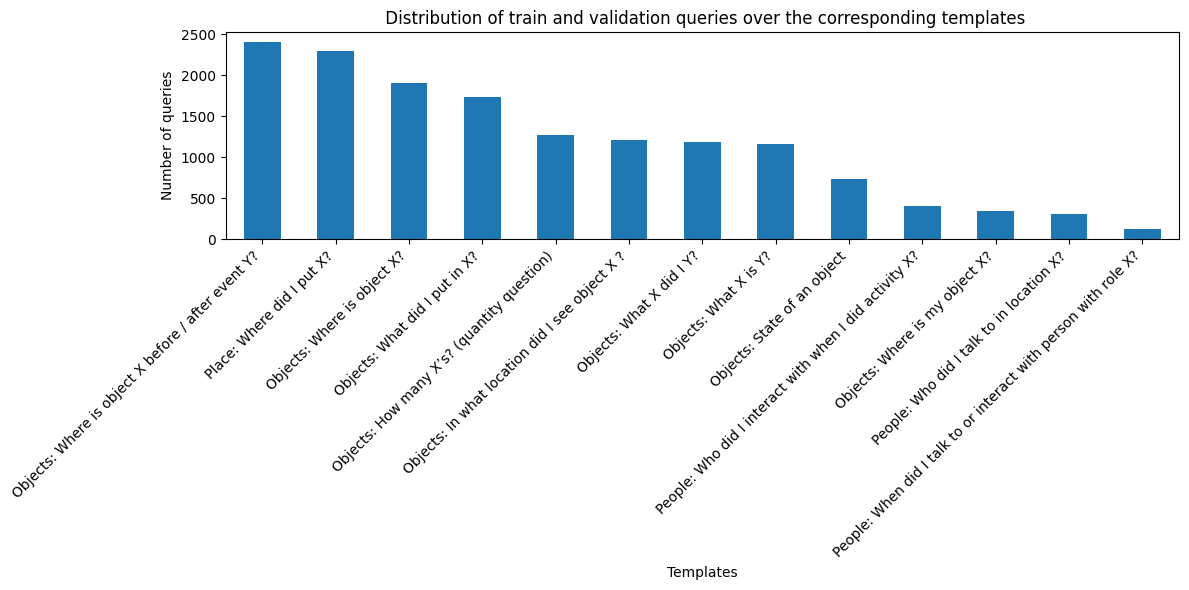

In [ ]:
# @title Distribution of queries over the corresponding templates across objects, place, and people categories

# Filtro fuori il test perchè il file unannotated non presenta la voce template
df = df_all[df_all.split != 'test']

# Raggruppo per template e conto quante query ci sono
tpl_counts = df.groupby('template').size()

# Disegno il bar plot ordinato
plt.figure(figsize=(12, 6))  # Più ampio per le etichette
tpl_counts.sort_values(ascending=False).plot(kind='bar')

# Titolo e etichette
plt.title(' Distribution of train and validation queries over the corresponding templates')
plt.ylabel('Number of queries')
plt.xlabel('Templates')

# Inclinare le etichette in modo leggibile
plt.xticks(rotation=45, ha='right')

# Impostare il layout per evitare che si sovrappongano
plt.tight_layout()

# Visualizzare il grafico
plt.show()


The challenging ‘Where is object X before/ after event Y?’ is the most popular template with around 2.500 queries, with a reasonable distribution over other templates.

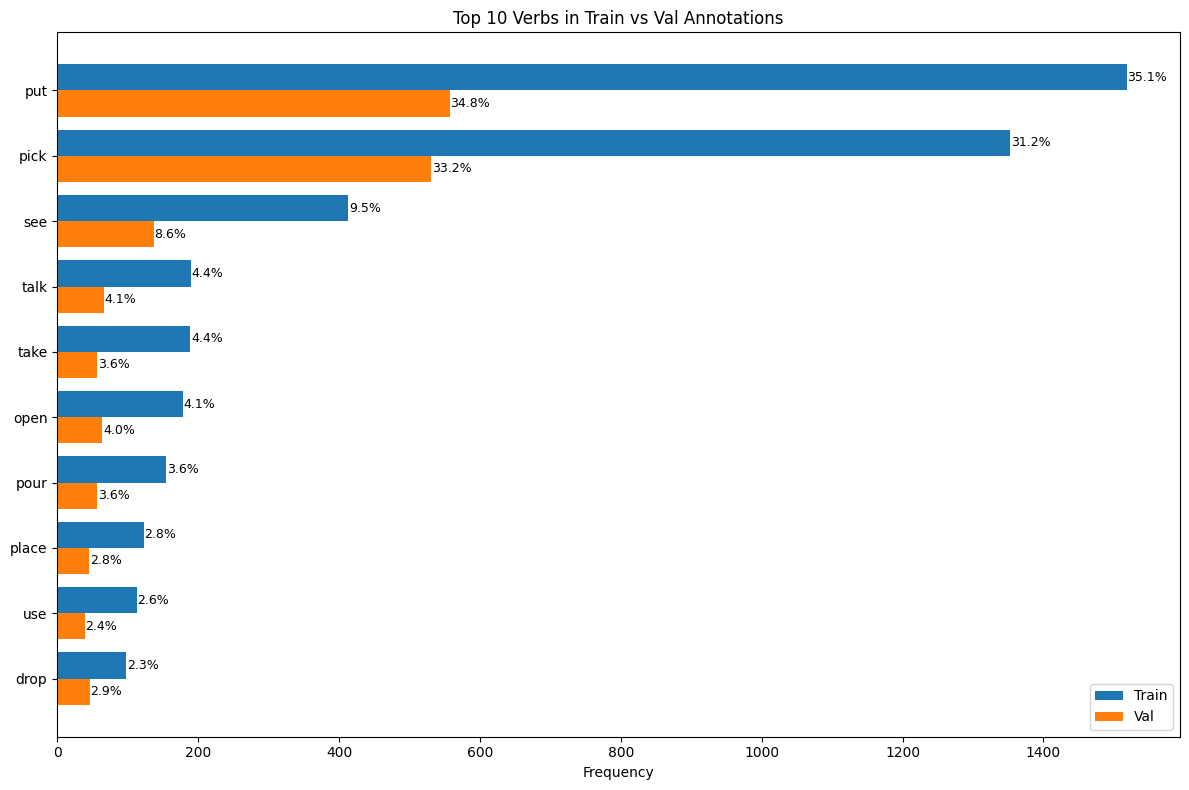

In [ ]:
# @title Distributions of verbs in the annotation files


# Inizializza i dizionari di conteggio verbi
verbs_counts_train = {}
verbs_counts_val = {}

# Funzione per contare verb_x e verb_y in un dataset
def count_verbs(data, counts_dict):
    for v in data.get('videos', []):
        for clip in v.get('clips', []):
            for ann in clip.get('annotations', []):
                for q in ann.get('language_queries', []):
                    for key in ('verb_x', 'verb_y'):
                        verb = q.get(key)
                        if verb and 'verb_not_applicable' not in verb and 'verb_not_in_list' not in verb:
                            counts_dict[verb] = counts_dict.get(verb, 0) + 1

# Applica la funzione a train e val
count_verbs(train, verbs_counts_train)
count_verbs(val,   verbs_counts_val)

# Scegli i top 20 verbi complessivi per frequenza
total_counts = {verb: verbs_counts_train.get(verb, 0) + verbs_counts_val.get(verb, 0)
                for verb in set(verbs_counts_train) | set(verbs_counts_val)}
top_verbs = sorted(total_counts, key=total_counts.get, reverse=True)[:10]

# Prepara i dati per il grafico
train_vals = [verbs_counts_train.get(v, 0) for v in top_verbs]
val_vals   = [verbs_counts_val.get(v, 0) for v in top_verbs]

# Percentuali
train_total = sum(train_vals)
val_total   = sum(val_vals)
train_pcts = [(v / train_total) * 100 for v in train_vals]
val_pcts   = [(v / val_total) * 100 for v in val_vals]

# Disegna il barh plot con due barre e percentuali
x = np.arange(len(top_verbs))
width = 0.4

plt.figure(figsize=(12, 8))
plt.barh(x - width/2, train_vals, height=width, label='Train', color='C0')
plt.barh(x + width/2, val_vals,   height=width, label='Val',   color='C1')
plt.yticks(x, top_verbs, fontsize=10)
plt.gca().invert_yaxis()

# Aggiungi percentuali sopra le barre
for i in x:
    plt.text(train_vals[i] + 1, x[i] - width/2, f"{train_pcts[i]:.1f}%", va='center', fontsize=9)
    plt.text(val_vals[i] + 1,   x[i] + width/2,   f"{val_pcts[i]:.1f}%", va='center', fontsize=9)

plt.xlabel('Frequency')
plt.title('Top 10 Verbs in Train vs Val Annotations')
plt.legend()
plt.tight_layout()
plt.show()


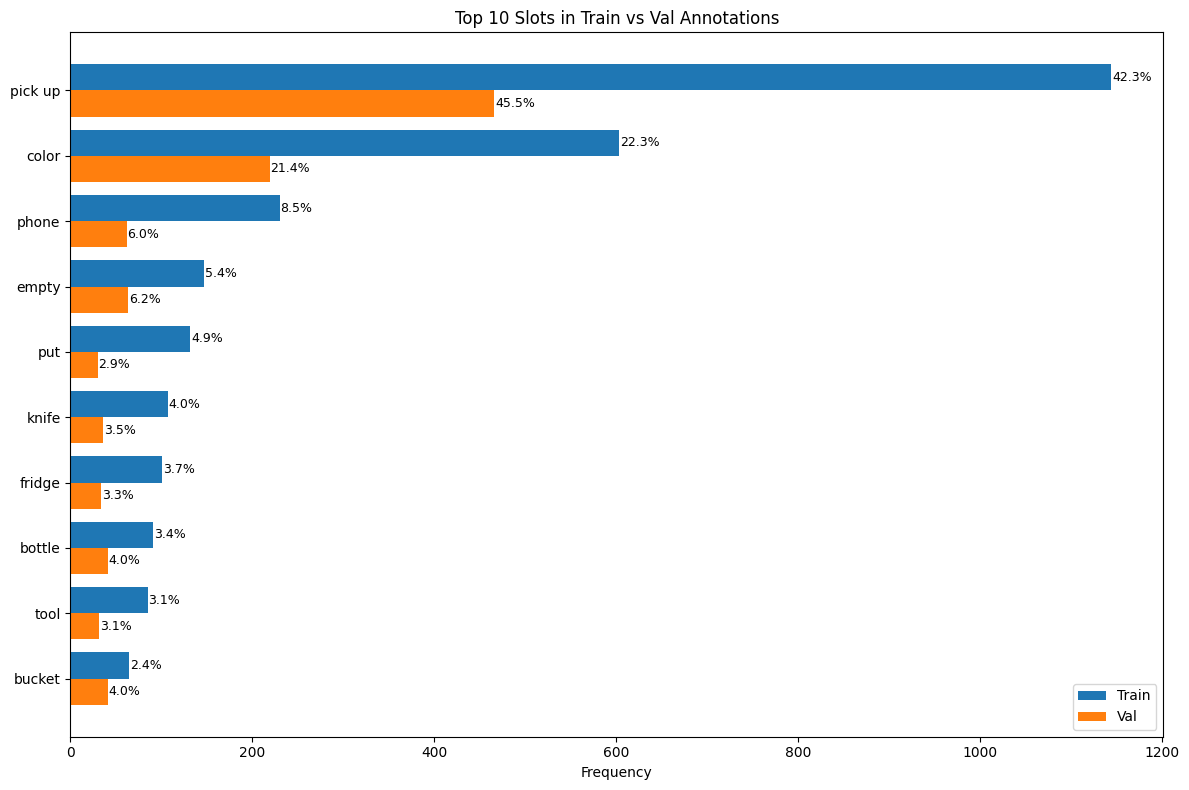

In [ ]:
# @title Distributions of slot in the annotation files


# Inizializza i dizionari di conteggio verbi
slots_counts_train = {}
slots_counts_val = {}

# Function to normalize slots (aggregate similar ones)
def normalize_slot(slot):
    slot = slot.lower().strip()
    if 'color' in slot:
        return 'color'
    if 'pick' in slot:
        return 'pick up'
    # Add other normalization rules here if needed
    return slot


# Funzione per contare verb_x e verb_y in un dataset
def count_slots(data, counts_dict):
    for v in data.get('videos', []):
        for clip in v.get('clips', []):
            for ann in clip.get('annotations', []):
                for q in ann.get('language_queries', []):
                    for key in ('slot_x', 'slot_y'):
                        slot = q.get(key)
                        if slot:
                            normalized_slot = normalize_slot(slot)
                            counts_dict[normalized_slot] = counts_dict.get(normalized_slot, 0) + 1

# Applica la funzione a train e val
count_slots(train, slots_counts_train)
count_slots(val,   slots_counts_val)

# Scegli i top 10 verbi complessivi per frequenza
total_counts = {slot: slots_counts_train.get(slot, 0) + slots_counts_val.get(slot, 0)
                for slot in set(slots_counts_train) | set(slots_counts_val)}
top_slots = sorted(total_counts, key=total_counts.get, reverse=True)[:10]

# Prepara i dati per il grafico
train_vals_s = [slots_counts_train.get(s, 0) for s in top_slots]
val_vals_s   = [slots_counts_val.get(s, 0) for s in top_slots]

# Percentuali
train_total_s = sum(train_vals_s)
val_total_s  = sum(val_vals_s)
train_pcts_s = [(s / train_total_s) * 100 for s in train_vals_s]
val_pcts_s  = [(s / val_total_s) * 100 for s in val_vals_s]

# Disegna il barh plot con due barre e percentuali
x = np.arange(len(top_slots))
width = 0.4

plt.figure(figsize=(12, 8))
plt.barh(x - width/2, train_vals_s, height=width, label='Train', color='C0')
plt.barh(x + width/2, val_vals_s,   height=width, label='Val',   color='C1')
plt.yticks(x, top_slots, fontsize=10)
plt.gca().invert_yaxis()

# Aggiungi percentuali sopra le barre
for i in x:
    plt.text(train_vals_s[i] + 1, x[i] - width/2, f"{train_pcts_s[i]:.1f}%", va='center', fontsize=9)
    plt.text(val_vals_s[i] + 1,   x[i] + width/2,   f"{val_pcts_s[i]:.1f}%", va='center', fontsize=9)

plt.xlabel('Frequency')
plt.title('Top 10 Slots in Train vs Val Annotations')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-8-293424846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['window_clipped'] = df['window_length'].apply(lambda x: x if x <= 60 else 60)


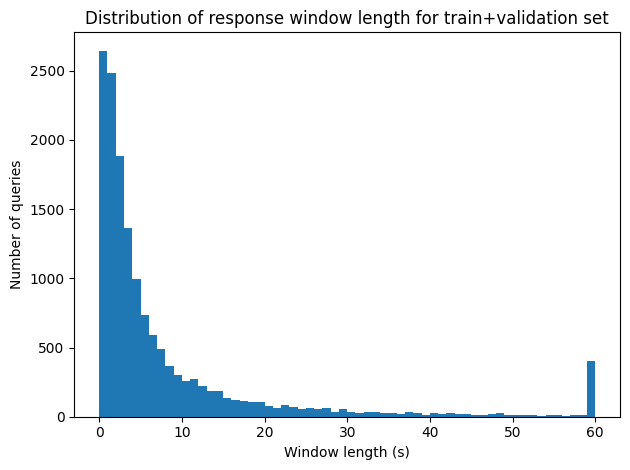

In [ ]:
# @title Distribution of response window length for NLQ
# 1) Prepara una nuova colonna dove tutto ciò che è >60 s diventa esattamente 60 s
df['window_clipped'] = df['window_length'].apply(lambda x: x if x <= 60 else 60)

# 2) Disegna l’istogramma da 0 a 60 secondi, con 60 bin da 1 s ciascuno
plt.figure()
df['window_clipped'].plot(
    kind='hist',
    bins=60,
    range=(0, 60),    # estende i bin da 0 fino a 60
)
plt.title('Distribution of response window length for train+validation set')
plt.xlabel('Window length (s)')
plt.ylabel('Number of queries')
plt.tight_layout()
plt.show()


Questa istogramma ci mostra chiaramente un pattern fortemente sbilanciato verso finestre brevi, con alcune osservazioni:

- Andamento generale \\
La maggior parte delle query ha finestre di risposta molto corte: 0–5 s concentra il grosso delle occorrenze (oltre il 50 % dei casi).
Dopo i 10 s la frequenza scende rapidamente, ma continuano a presentarsi finestre fino a 30–40 s, sebbene in quantità via via minori.
- Outlier raggruppati>60 s \\
Tutte le finestre più lunghe di un minuto sono state aggregate nell’ultimo bin a 60 s. Questi ~400 casi suggeriscono che poche query richiedono di “sfogliare” un intero minuto di video per trovare la risposta. La coda lunga indica che il task richiede anche di gestire sequenze di risposta più estese, seppure raramente.

La distribuzione conferma che il benchmark NLQ è dominato da query con finestre rapidissime, ma include anche una minoranza significativa di casi “di resistenza” su durate molto più lunghe.



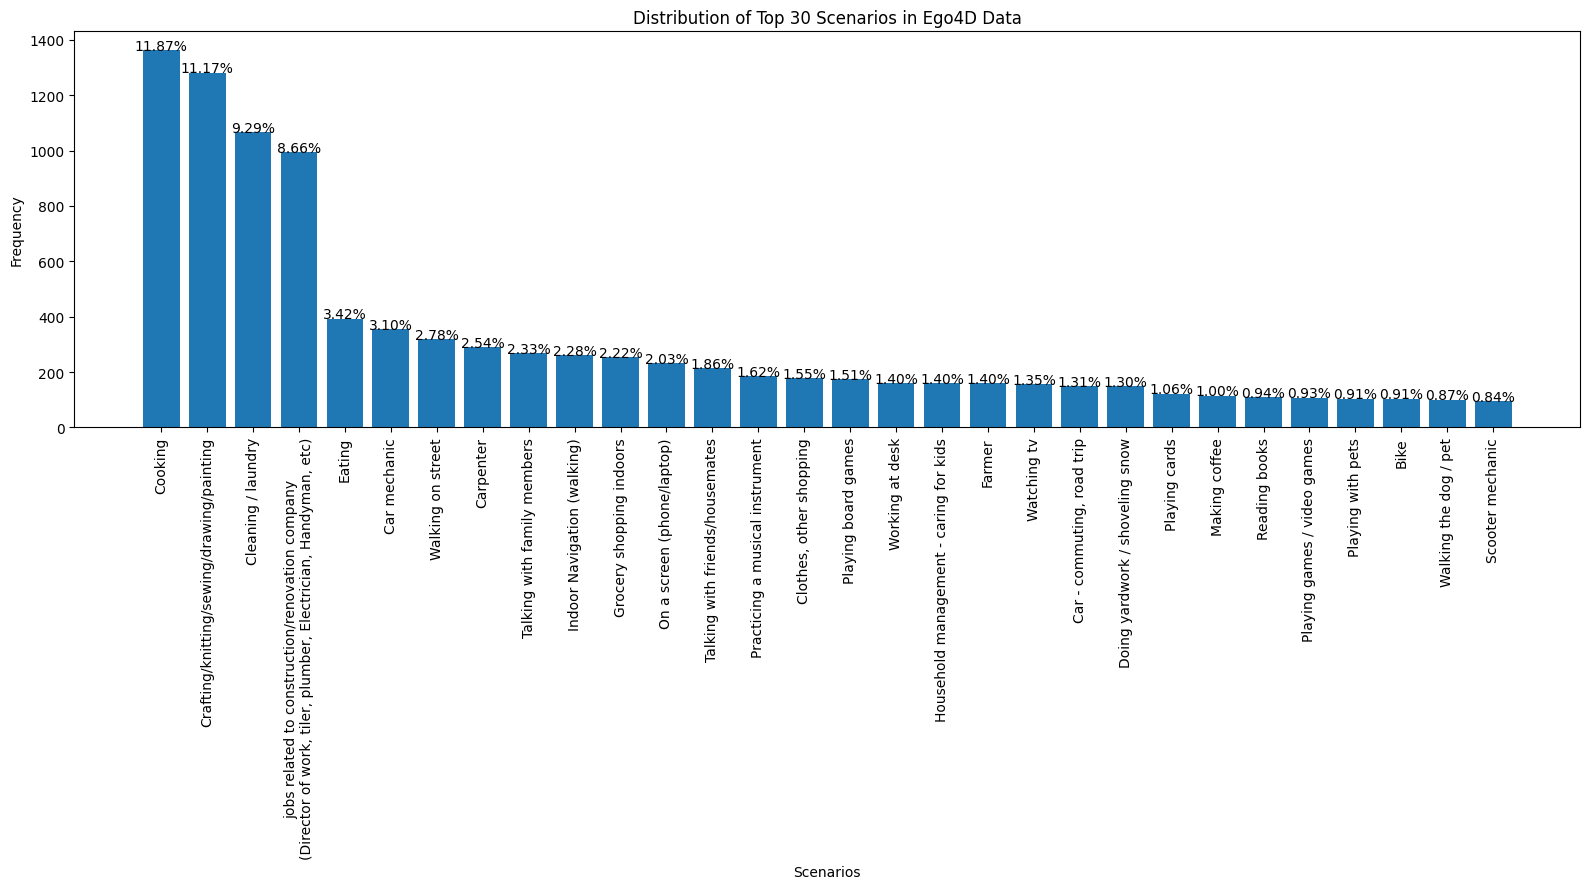

Cooking: 11.87%
Crafting/knitting/sewing/drawing/painting: 11.17%
Cleaning / laundry: 9.29%
jobs related to construction/renovation company
(Director of work, tiler, plumber, Electrician, Handyman, etc): 8.66%
Eating: 3.42%
Car mechanic: 3.10%
Walking on street: 2.78%
Carpenter: 2.54%
Talking with family members: 2.33%
Indoor Navigation (walking): 2.28%
Grocery shopping indoors: 2.22%
On a screen (phone/laptop): 2.03%
Talking with friends/housemates: 1.86%
Practicing a musical instrument: 1.62%
Clothes, other shopping: 1.55%
Playing board games: 1.51%
Working at desk: 1.40%
Household management - caring for kids: 1.40%
Farmer: 1.40%
Watching tv: 1.35%
Car - commuting, road trip: 1.31%
Doing yardwork / shoveling snow: 1.30%
Playing cards: 1.06%
Making coffee: 1.00%
Reading books: 0.94%
Playing games / video games: 0.93%
Playing with pets: 0.91%
Bike: 0.91%
Walking the dog / pet: 0.87%
Scooter mechanic: 0.84%
Percentuale dei primi 30 secnari: 83.86478480571526


In [ ]:
# @title Distribution over scenarios for the Ego4d dataset
scenarios = []
for video in ego4d ["videos"]:
    if "scenarios" in video:
          scenarios.extend(video["scenarios"])

# Count the occurrences of each scenario
scenario_counts = {}
for scenario in scenarios:
    scenario_counts[scenario] = scenario_counts.get(scenario, 0) + 1

k=30

# Sort scenarios by count in descending order
sorted_scenarios = sorted(scenario_counts.items(), key=lambda item: item[1], reverse=True)

# Get the top 10 scenarios and their counts
top_k_scenarios = sorted_scenarios[:k]
top_k_scenario_names = [scenario[0] for scenario in top_k_scenarios]
top_k_counts = [scenario[1] for scenario in top_k_scenarios]

# Calculate total number of scenarios
total_scenarios = sum(scenario_counts.values())

# Calculate percentages
percentages = [(count / total_scenarios) * 100 for count in top_k_counts]

# Create the histogram
plt.figure(figsize=(16, 9))
plt.bar(top_k_scenario_names, top_k_counts)
plt.xlabel("Scenarios")
plt.ylabel("Frequency")
plt.title(f"Distribution of Top {k} Scenarios in Ego4D Data")
plt.xticks(rotation=90)

# Add percentage labels above each bar
for i, v in enumerate(top_k_counts):
    plt.text(i, v + 1, f"{percentages[i]:.2f}%", ha='center')

plt.tight_layout()
plt.show()

# Print the percentage of each top k scenario
for i in range(len(top_k_scenario_names)):
    print(f"{top_k_scenario_names[i]}: {percentages[i]:.2f}%")


print(f"Percentuale dei primi {k} secnari: {sum(percentages)}")

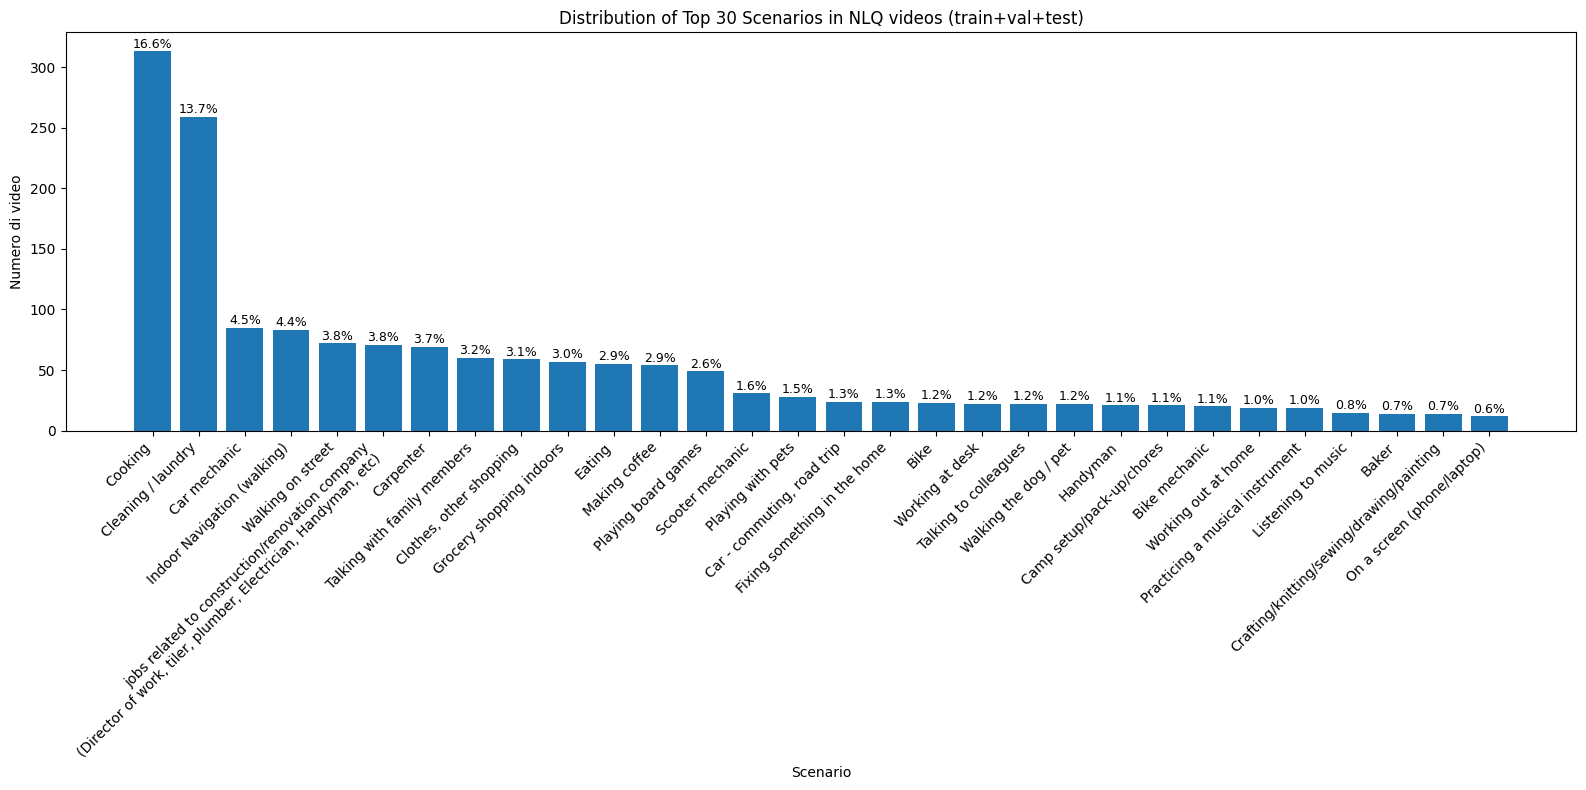

Cooking: 16.58%
Cleaning / laundry: 13.72%
Car mechanic: 4.50%
Indoor Navigation (walking): 4.40%
Walking on street: 3.81%
jobs related to construction/renovation company
(Director of work, tiler, plumber, Electrician, Handyman, etc): 3.76%
Carpenter: 3.65%
Talking with family members: 3.18%
Clothes, other shopping: 3.12%
Grocery shopping indoors: 3.02%
Eating: 2.91%
Making coffee: 2.86%
Playing board games: 2.60%
Scooter mechanic: 1.64%
Playing with pets: 1.48%
Car - commuting, road trip: 1.27%
Fixing something in the home: 1.27%
Bike: 1.22%
Working at desk: 1.17%
Talking to colleagues: 1.17%
Walking the dog / pet: 1.17%
Handyman: 1.11%
Camp setup/pack-up/chores: 1.11%
Bike mechanic: 1.06%
Working out at home: 1.01%
Practicing a musical instrument: 1.01%
Listening to music: 0.79%
Baker: 0.74%
Crafting/knitting/sewing/drawing/painting: 0.74%
On a screen (phone/laptop): 0.64%
Somma % primi 30: 86.71%


In [ ]:
# @title Distribution over scenarios for the NLQ annotations

# 1) Estrai l’insieme di video_uid usati in train/val/test
uids = set()
for data in (train, val, test):
    for v in data.get('videos', []):
        uids.add(v['video_uid'])

# 2) Conta gli scenarios solo per questi video
scenario_counts = {}
for video in ego4d.get('videos', []):
    vid = video['video_uid']
    if vid not in uids:
        continue
    for sc in video.get('scenarios', []):
        scenario_counts[sc] = scenario_counts.get(sc, 0) + 1

# 3) Prendi i top-k e calcola le percentuali
k = 30
sorted_items = sorted(scenario_counts.items(), key=lambda x: x[1], reverse=True)
top_k = sorted_items[:k]
names, counts = zip(*top_k)
total = sum(scenario_counts.values())
percentages = [(c/total)*100 for c in counts]

# 5) Plot
plt.figure(figsize=(16, 8))
bars = plt.bar(names, counts)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Numero di video')
plt.xlabel('Scenario')
plt.title(f'Distribution of Top {30} Scenarios in NLQ videos (train+val+test)')

# Annotazioni con percentuali
for i, b in enumerate(bars):
    height = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, height + 0.5,
             f"{percentages[i]:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 4) Output percentuali in console
for name, pct in zip(names, percentages):
    print(f"{name}: {pct:.2f}%")
print(f"Somma % primi {k}: {sum(percentages):.2f}%")


/tmp/ipython-input-11-1956274271.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=top_templates, showfliers=False)


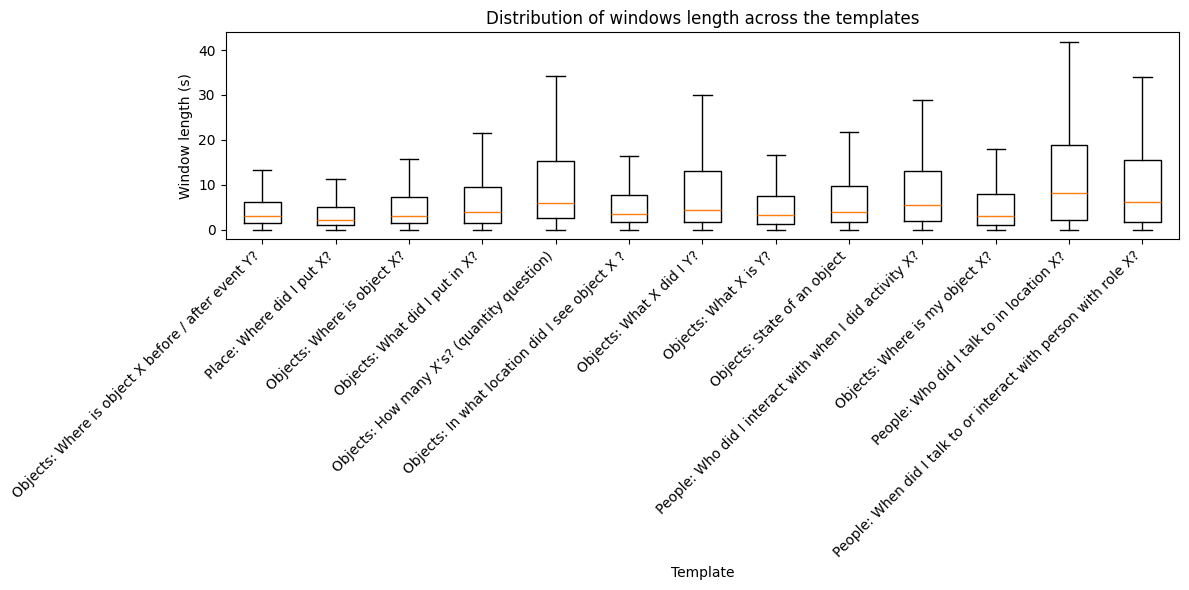

In [ ]:
# 1) Scegli i top-k template per numero di query

tpl_counts = df_all[df_all.split!='test'].groupby('template').size()
top_templates = tpl_counts.sort_values(ascending=False).index.tolist()

# 2) Prepara i dati per il boxplot: una lista di liste di window_length
data_to_plot = [
    df_all[(df_all.template == tpl) & (df_all.split!='test')]['window_length'].values
    for tpl in top_templates
]

# 3) Disegna il boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(data_to_plot, labels=top_templates, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Window length (s)')
plt.xlabel('Template')
plt.title(f'Distribution of windows length across the templates')
plt.tight_layout()
plt.show()




RECAP SU COME LEGGERE UN BLOX-PLOT \\
Bordo inferiore del rettangolo (“box”) → Primo quartile (Q1, 25° percentile)

Linea interna al box (di solito arancione o nera) → Mediana (50° percentile)

Bordo superiore del box → Terzo quartile (Q3, 75° percentile)

LETTURA E COMMENTI SUL GRAFICO \\
- Diversa scala di durata a seconda del template\\
Alcuni template (“People: When did I talk to or interact with person with role X?”, “Objects: How many X’s? (quantity question)”, "Who did I talk to?") hanno mediana e IQR decisamente più alti.
Altri (“Place: Where did I put X?”, “Objects: Where is object X before/after event Y?”) mostrano mediana intorno ai 2–3 s e code molto corte, con pochissimi outlier.

- Variabilità interna al template \\
I template legati a persone e a quantità evidenziano la IQR (intervallo tra primo e terzo quartile) più ampia: cioè la durata di risposta per quella domanda cambia molto da caso a caso.
Al contrario, template tipo “object identity” (“What is X?”, “What did I pick up X?”) hanno distribuzioni più compatte, con meno dispersione.

- Outlier e code \\
Molti template presentano qualche outlier verso durate molto lunghe (> 40 s), segno che in pochi casi la risposta si estende su porzioni molto ampie di video.
Questi “long tail” sono più marcati per i template che richiedono di ricostruire interazioni complesse (ad es. “People: When did I talk to…”) o quantità.

- Conseguenze pratiche \\
Modelli di localizzazione probabilmente faranno più fatica sui template con finestre molto variabili e lunghe, perché è più difficile imparare a prevedere esattamente lo span esatto su 30+ secondi.
I template con distribuzione ristretta e durate brevi (“Where did I put X?”, “What is X?”) sono intrinsecamente più facili da modellare in termini di durata, ma richiedono maggiore precisione temporale (piccoli errori di 1–2 s contano molto).

- Utilizzo per il confronto con i risultati \\
Quand’anche misuri le durate di span predetti dal tuo modello, potrai plottare lo stesso box-plot e verificare: se il modello tende a sottostimare sistematicamente i template con mediana alta e se gli outlier (predizioni troppo lunghe o troppo corte) sono concentrati su certe tipologie di domanda.


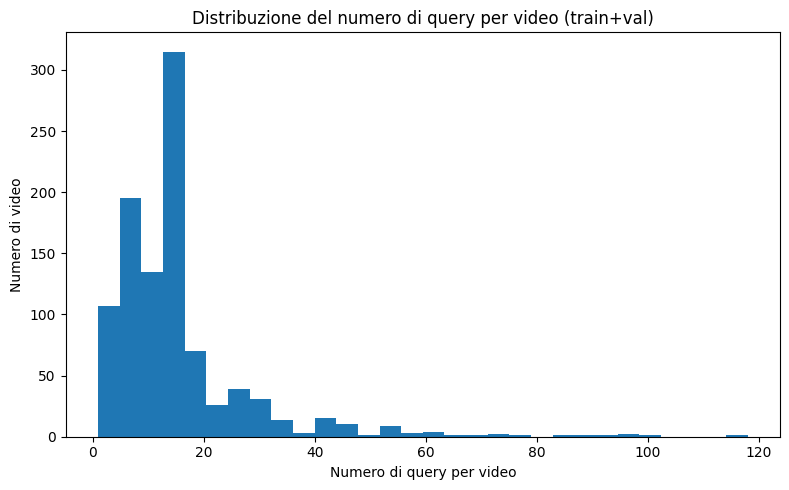

In [ ]:

# 2. Estrazione di video_uid e split da train/val
rows = []
for split, data in [('train', train), ('val', val)]:
    for v in data['videos']:
        vid = v['video_uid']
        for clip in v['clips']:
            for ann in clip.get('annotations', []):
                for q in ann.get('language_queries', []):
                    rows.append({'video_uid': vid, 'split': split})

df = pd.DataFrame(rows)

# 3. Conteggio delle query per video
queries_per_video = df.groupby('video_uid').size()

# 4. Istogramma
plt.figure(figsize=(8, 5))
queries_per_video.plot(kind='hist', bins=30)
plt.title('Distribuzione del numero di query per video (train+val)')
plt.xlabel('Numero di query per video')
plt.ylabel('Numero di video')
plt.tight_layout()
plt.show()


La maggioranza dei video (oltre il 60 %) ha meno di 15 query ciascuno.
Notiamo un picco tra 5 e 15 query per video: questi video sono quelli maggiormente sfruttati dalle annotazioni NLQ.

Una coda lunga fino a ~120 query, ma questi casi sono rari:
pochi video — probabilmente quelli più ricchi di contenuto o più lunghi — arrivano a 30, 50 o addirittura 100+ query.

In [ ]:
import json
def count_zero_length(nlq_data):
    total = 0
    zero_length = 0
    for v in nlq_data.get('videos', []):
        for clip in v.get('clips', []):
            for ann in clip.get('annotations', []):
                for q in ann.get('language_queries', []):
                    total += 1
                    start = q.get('clip_start_sec')
                    end   = q.get('clip_end_sec')
                    if start is not None and end is not None and (end - start) == 0:
                        zero_length += 1
    return total, zero_length

train_total, train_zero = count_zero_length(train)
val_total,   val_zero   = count_zero_length(val)

print(f"Train: {train_zero} zero-length queries su {train_total} totali")
print(f"Val:   {val_zero} zero-length queries su {val_total} totali")


Train: 966 zero-length queries su 11296 totali
Val:   342 zero-length queries su 3875 totali


Le queries con window_length nulla esistono sia nel val che nel train, possono essere la causa di IoU a 0 per un numero tanto grande di casi.

Numero di query rispetto alla lunghezza normallizata del video


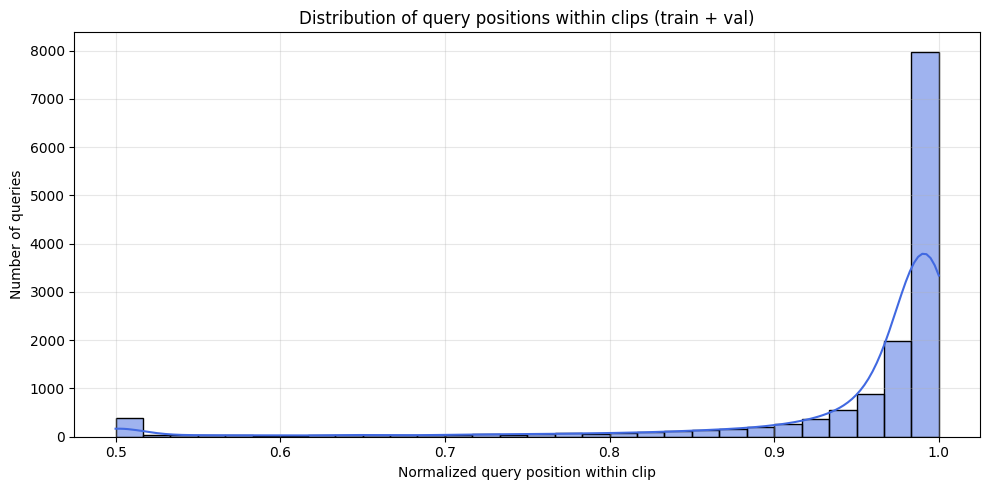

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# --- Estrazione delle query ---
def extract_queries(data):
    rows = []
    for v in data['videos']:
        split = v.get('split')
        vid = v['video_uid']
        for clip in v['clips']:
            for ann in clip.get('annotations', []):
                for q in ann.get('language_queries', []):
                    if 'clip_start_sec' in q and 'clip_end_sec' in q:
                        clip_start = q['clip_start_sec']
                        clip_end = q['clip_end_sec']
                        window_length = clip_end - clip_start
                        if window_length > 0:
                            row = {
                                'split': split,
                                'video_uid': vid,
                                'clip_start_sec': clip_start,
                                'clip_end_sec': clip_end,
                                'window_length': window_length,
                                # posizione normalizzata nel clip
                                'query_position_norm': (clip_start + window_length / 2) / (clip_end)
                            }
                            rows.append(row)
    return pd.DataFrame(rows)

# --- Crea il dataframe completo ---
df_train = extract_queries(train)
df_val = extract_queries(val)
df_all = pd.concat([df_train, df_val], ignore_index=True)

# --- Rimozione di eventuali valori strani ---
df_all = df_all[(df_all['query_position_norm'] >= 0) & (df_all['query_position_norm'] <= 1)]

# --- Plot della distribuzione normalizzata ---
plt.figure(figsize=(10, 5))
sns.histplot(df_all['query_position_norm'], bins=30, kde=True, color='royalblue')
plt.xlabel('Normalized query position within clip')
plt.ylabel('Number of queries')
plt.title('Distribution of query positions within clips (train + val)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Verifico quanto le query vengono ripetute

Quanto le query vengono ripetute nello stesso video

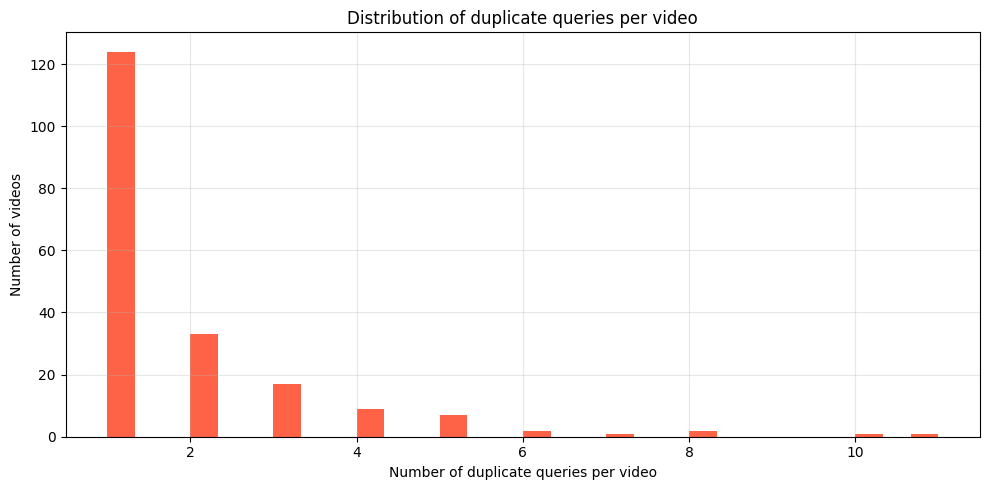

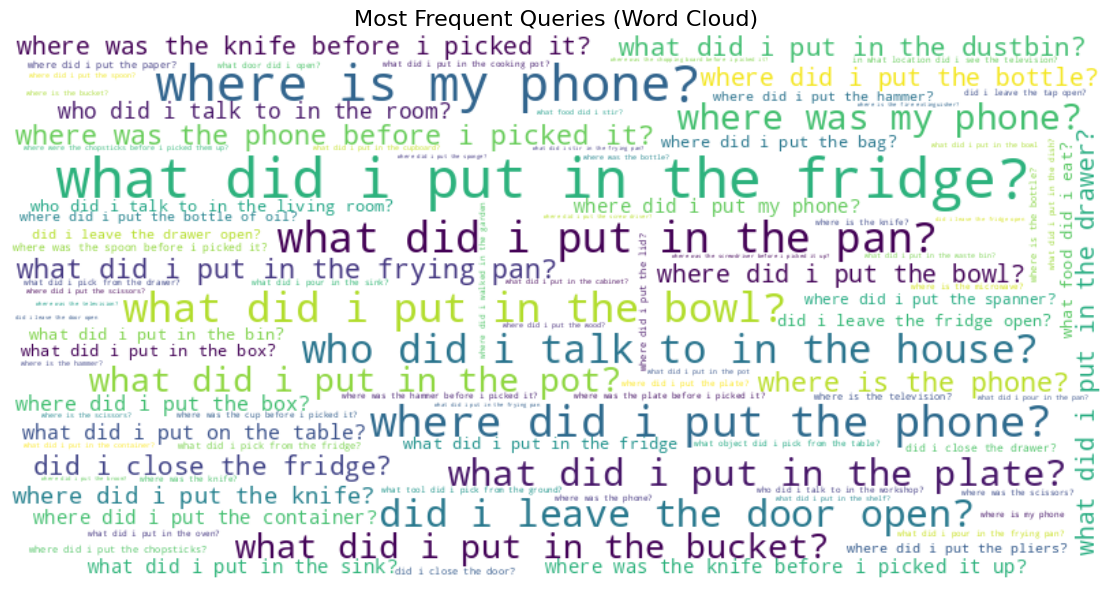

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json
from collections import Counter

# --- Estrazione delle query con testo e video_uid ---
def extract_queries(data):
    rows = []
    for v in data.get('videos', []): # Use .get() for safety
        split = v.get('split')
        vid = v.get('video_uid') # Use .get() for safety
        if not vid: # Skip if video_uid is missing
            continue
        for clip in v.get('clips', []): # Use .get() for safety
            for ann in clip.get('annotations', []): # Use .get() for safety
                for q in ann.get('language_queries', []): # Use .get() for safety
                    query_text = q.get('query') # Use .get() to safely access 'query'
                    if query_text: # Check if query_text is not None or empty
                        rows.append({
                            'split': split,
                            'video_uid': vid,
                            'query': query_text.strip().lower()  # pulizia base
                        })
    return pd.DataFrame(rows)

# --- Crea il dataframe completo ---
df_train = extract_queries(train)
df_val = extract_queries(val)
df_all = pd.concat([df_train, df_val], ignore_index=True)

# --- Istogramma: quante query duplicate ci sono per video ---
# Conta quante volte ogni query appare per video
dup_counts = df_all.groupby(['video_uid', 'query']).size().reset_index(name='count')

# Teniamo solo le query che si ripetono almeno 2 volte
dup_counts = dup_counts[dup_counts['count'] > 1]

# Conteggio: quante query duplicate per video
dup_per_video = dup_counts.groupby('video_uid').size()

# --- Plot istogramma ---
plt.figure(figsize=(10, 5))
if not dup_per_video.empty:
    dup_per_video.plot(kind='hist', bins=30, color='tomato')
    plt.xlabel('Number of duplicate queries per video')
    plt.ylabel('Number of videos')
    plt.title('Distribution of duplicate queries per video')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No duplicate queries found in any video.")


# --- Word Cloud delle query più frequenti ---
query_counts = df_all['query'].value_counts()

if not query_counts.empty:
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate_from_frequencies(query_counts.to_dict())

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Queries (Word Cloud)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No queries found for word cloud.")